# 深層生成モデルスプリングセミナー 第3回演習

本演習では，色々な種類のGAN (Generative Adversarial Networks) を実装し，その工夫を比較していきます．

## 目次

1. 前準備

1. ネットワークの定義
  - Generatorの定義
  - Discriminatorの定義

1. 各モデルの学習
  - GAN
  - LSGAN (Least Squares GAN)
  - WGAN (Wasserstein GAN)
  - DRAGAN (Deep Regret Analytic GAN)
  - BEGAN (Boundary Equilibrium GAN)
  - SNGAN (Spectral Normalization GAN)

In [367]:
import PIL
PIL.PILLOW_VERSION = PIL.__version__

import torch, time, os, pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import Parameter
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.autograd import grad
from IPython import display
import pylab as pl
import time
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple

from tqdm import tqdm

import matplotlib.pyplot as plt

%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES '] = '0'

## 1.前準備

### 1.1. データローダー

学習用のデータとして`mnist`，`fashion-mnist`，`cifar10`を使用します．以下でそのためのデータローダを用意します．

In [368]:
class MyTransforms:
    def __init__(self) -> None:
        pass

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: fix to original transforms
        x = torch.from_numpy(x.astype(np.float32))  # example
        return x

In [369]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df, features, labels):
        self.features_values = df[features].values
        self.labels = df[labels].values

    # len()を使用すると呼ばれる
    def __len__(self):
        return len(self.features_values)

    # 要素を参照すると呼ばれる関数    
    def __getitem__(self, idx):
        features_x = torch.FloatTensor(self.features_values[idx])
        labels = torch.LongTensor(self.labels[idx])
        return features_x, labels

In [370]:
def dataloader(dataset, input_size, batch_size, split='train'):
    transform = transforms.Compose([transforms.Resize((input_size, input_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
    # 実装上の簡便性のため, 白黒画像は3チャンネル分コピーする
    # mnist, fashion-mnist
    transform2 = transforms.Compose([transforms.Resize(input_size),
                                     transforms.ToTensor(),
                                     transforms.Lambda(lambda x: x.repeat(3,1,1)),
                                     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
    transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    ])
    
    if dataset == 'mnist':
        data_loader = DataLoader(
            datasets.MNIST('data/mnist', train=True, download=True, transform=transform2),
            batch_size=batch_size, shuffle=True)
    elif dataset == 'fashion-mnist':
        data_loader = DataLoader(
            datasets.FashionMNIST('data/fashion-mnist', train=True, download=True, transform=transform2),
            batch_size=batch_size, shuffle=True)
    elif dataset == 'cifar10':
        data_loader = DataLoader(
            datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform),
            batch_size=batch_size, shuffle=True)
    elif dataset == "skin":
        dataset = datasets.ImageFolder(root="SkinData/3/0", transform=transform)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=21)

    return data_loader

### 1.2.  初期化の定義

重みの初期値を設定するための関数です．モデル構築の際に使用します．

In [371]:
# Xavierの初期化, Heの初期化など採用するネットワーク構造, 活性化関数に合わせた初期化手法は多数
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

### 1.3. 学習プロセスの表示のための関数

モデルの学習中に，Lossの推移過程と生成例を表示するための関数です．学習のときに使用します．

In [372]:
def display_process(hist, G, image_frame_dim, sample_z_, fix=True):
    plt.gcf().clear()

    fig = plt.figure(figsize=(24, 15))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

    x = range(len(hist['D_loss']))

    y1 = hist['D_loss']
    y2 = hist['G_loss']

    ax1 = fig.add_subplot(1, 2, 1)

    ax1.plot(x, y1, label='D_loss')
    ax1.plot(x, y2, label='G_loss')

    ax1.set_xlabel('Iter')
    ax1.set_ylabel('Loss')

    ax1.legend(loc=4)
    ax1.grid(True)

    samples = G(sample_z_)
    samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
    samples = (samples + 1) / 2

    for i in range(image_frame_dim*image_frame_dim):
        ax = fig.add_subplot(image_frame_dim, image_frame_dim*2, (int(i/image_frame_dim)+1)*image_frame_dim+i+1, xticks=[], yticks=[])
        if samples[i].shape[2]==3:
            ax.imshow(samples[i])
        else:
            ax.imshow(samples[i][:, :, 0], cmap='gray')

## 2.ネットワークの定義

<p align='center'><img src='https://github.com/SeanNobel/DGM2022/blob/main/GAN_overview.png?raw=True' width='60%'></p>

<br>

本章では様々なモデルを実装しますが，基本的に同一のGenerator $G$とDiscriminator $D$を使用します．それぞれを下記のように定義します．

### 2.1. Generatorの定義

In [373]:
class generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            # https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

### 2.2. Discriminatorの定義

In [374]:
class discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32, sig_out=True):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
        )
        # MSE, Wassersteinを使うものではsigmoidを追加しない
        if sig_out:
            self.fc.add_module('sigmoid', nn.Sigmoid())

        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

## 3.各モデルの学習

GANの研究は盛んに行われており，様々なGANのモデルが提案されています．本章では，その様々なモデルの実装を行います．

### 3.1 GAN

まずは一般的なGANのモデルを実装します．学習においては以下の関数を最大化します．


\begin{aligned} L _ { D } ^ { G A N } & = \mathbb{E} _{p_{data}(x)}[ \log ( D ( x ) ) ] + \mathbb{E}_{p(z)} [ \log ( 1 - D ( G ( z ) ) ) ] \\ L _ { G } ^ { G A N } & = \mathbb{E}_{p(z)} [ \log ( D ( G ( z ) ) ) ] \end{aligned}

論文: [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)

<!-- 以下追加 -->

- 本来Generatorの最適化は$E_{p(z)}[\log (1 - D(G(z)))]$の最小化ですが，勾配が消失しやすいため，実装上は上記目的関数の最大化が行われます．（厳密にはJSダイバージェンスの最小化ではなくなる）

In [375]:
class GAN(object):
    def __init__(self, dataset='skin', epoch=1):
        self.epoch = epoch
        self.sample_num = 21
        self.batch_size = 21
        self.input_size = 64
        self.z_dim = 64
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.dataset = dataset # mnist, fashion-mnist, cifar10

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2))

        self.G.cuda()
        self.D.cuda()
        self.BCE_loss = nn.BCELoss().cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader): # ( batch, 3, 28, 28 )
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                # zを一様分布からサンプリング．ガウス分布や色々な特殊な分布があり得る
                # https://pytorch.org/docs/stable/generated/torch.rand.html
                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_) # ( batch, 1 )
                # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
                # y_real_ = 1, y_fake_ = 0
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                # 最大化→マイナスを取った値について最小化
                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()# WRITE ME

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                # GAN originalではなく, 勾配が消えないように工夫したloss, そのため第二引数がy_real(=1)
                # https://github.com/soumith/ganhacks のtip2
                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                # ディスプレイ
                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()

        plt.close()
        print("Training finish!")

学習データセットとして，MNIST，Fashion MNIST，Cifar10を使用できます．モデルの引数で利用するデータセットを変更できます．

それぞれのデータセットで学習過程をみてみましょう．

In [376]:
# colab上での実行時間目安: 92秒
gan = GAN()
gan.train()

FileNotFoundError: Couldn't find any class folder in SkinData/3/0.

In [ ]:
# colab上での実行時間目安: 93秒
gan = GAN(dataset='skin')
gan.train()

Training finish!


In [ ]:
# colab上での実行時間目安: 246秒
gan = GAN(dataset='cifar10', epoch=3)
gan.train()

 50%|████▉     | 84672512/170498071 [00:11<00:11, 7427408.15it/s] 


KeyboardInterrupt: 

### 3.2 LSGAN

[Least Squares Generative Adversarial Networks](https://arxiv.org/abs/1611.04076)(LSGAN)は二乗誤差を用いる手法です．GANとの違いは，目的関数を正解ラベルに対する二乗誤差としているところです．

学習においては以下の関数を最小化します．

\begin{aligned} L _ { D } ^ { L S G A N } & = \mathbb{E} _{p_{data}(x)}\left[ ( D ( x ) - 1 ) ^ { 2 } \right] + \mathbb{E}_{p(z)} \left[ D ( G ( z ) ) ^ { 2 } \right] \\ L _ { G } ^ { L S G A N } & = \mathbb{E}_{p(z)} \left[ ( D ( G ( z ) ) - 1 ) ^ { 2 } \right] \end{aligned}

<!-- 以下追加 -->

- LSGANは，GANで指摘されていた**Gについての勾配消失問題を緩和します**．MSEはサンプルがdecision boundaryから離れていることにペナルティを課すため，「Dによって実データだと判別されているものの実データとは離れた空間にいる」Gのサンプルについても，大きな勾配を作ることができるからです．

- 論文で実際に（$p_{data}+p_{\theta}$と$2p_{\theta}$の間の）ピアソンの$\chi^2$ダイバージェンスの最小化に対応すると示されたのは以下の目的関数の最小化ですが，パフォーマンスは変わらないことが述べられています．

<small>
\begin{aligned}
L _ { D } ^ { L S G A N } & = \mathbb{E} _{p_{data}(x)}\left[ ( D ( x ) - 1 ) ^ { 2 } \right] + \mathbb{E}_{p(z)} \left[ ( D ( G ( z ) ) + 1 ) ^ { 2 } \right] \\ L _ { G } ^ { L S G A N } & = \mathbb{E}_{p(z)} \left[ D ( G ( z ) ) ^ { 2 } \right]
\end{aligned}
</small>

<!-- 実装でDの出力にsigmoidをかけるようになっていたので修正 -->

In [ ]:
class LSGAN(object):
    def __init__(self, dataset='mnist'):
        self.epoch = 2 # 1
        self.sample_num = 16
        self.batch_size = 64
        self.input_size = 28
        self.z_dim = 62
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.dataset = dataset

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size, sig_out=False)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2))

        self.G.cuda()
        self.D.cuda()
        self.MSE_loss = nn.MSELoss().cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = self.MSE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.MSE_loss(D_fake, self.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                G_loss = self.MSE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()

        plt.close()
        print("Training finish!")

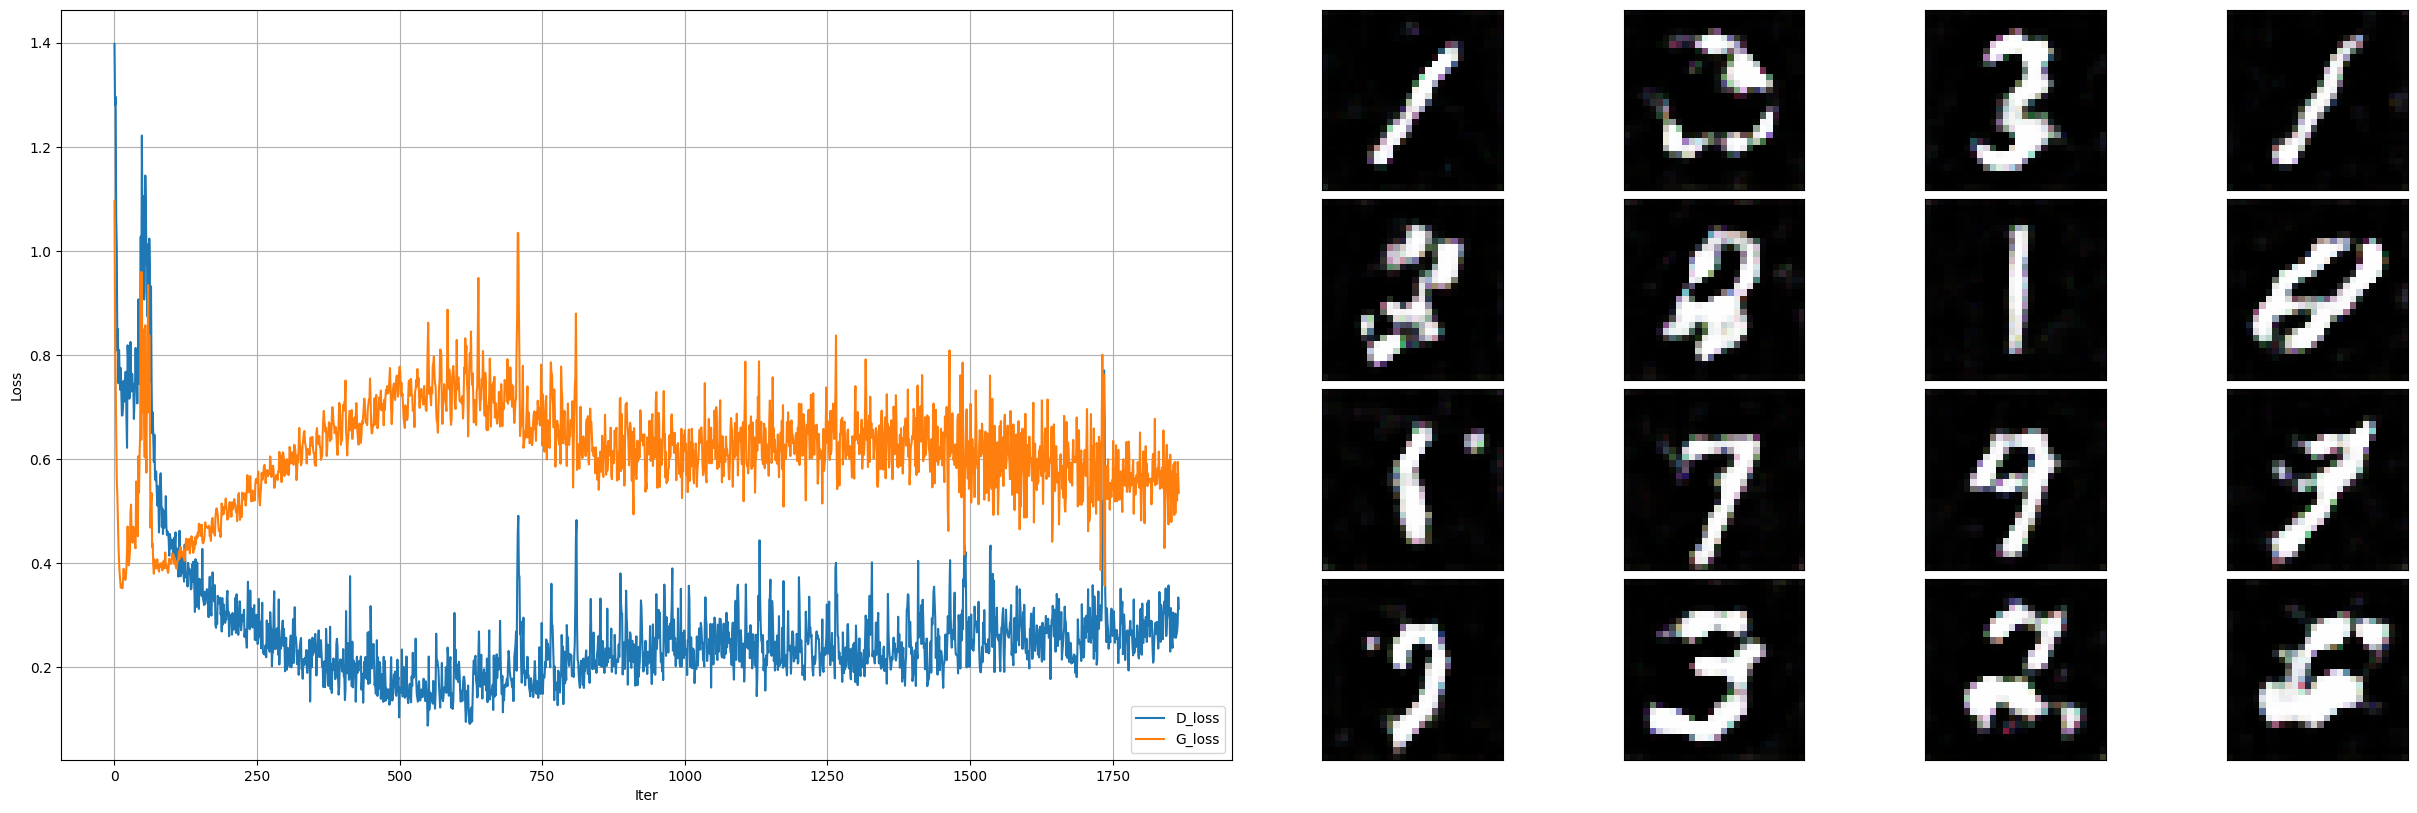

Training finish!


In [ ]:
# colab上での実行時間目安: 180秒
lsgan = LSGAN() # 他のデータセットで学習する場合: LSGAN(dataset='fashion-mnist'), LSGAN(dataset='cifar10')
lsgan.train()

### 3.3 WGAN

通常のGANはJensen-Shannonダイバージェンスを指標に確率密度間の距離を近づける学習とみなせますが，勾配消失問題によって学習がうまくいかなくなることが知られています．そのため，別の指標としてWasserstein距離を用いたのが[Wasserstein GAN](https://arxiv.org/abs/1701.07875) (WGAN)です．

**Wasserstein距離**
- 分布から分布への最適輸送距離
- $p_{data}(x)$ と $p_{\theta}(x)$ のサポートが被っていない状態でも，距離を得ることができる

<br>

役割としては，$D$がWasserstein距離を近似し，$G$がこれを最小化します．$D(x)$がWasserstein距離として意味を持つためにはリプシッツ関数である必要があります．この制約を満たすために，パラメータをクリップしています．

学習では以下の関数を最大化します．

\begin{aligned} L _ { D } ^ { W G A N } & = \mathbb{E} _{p_{data}(x)}[ D ( x ) ] - \mathbb{E}_{p(z)} [ D ( G ( z ) ) ] \\ L _ { G } ^ { W G A N } & = \mathbb{E}_{p(z)} [ D ( G ( z ) ) ] \end{aligned}

<!-- 以下追加 -->

- Wasserstein距離

\begin{eqnarray}
W(p_{data}, p_{\theta})
&=& \sup_{||f||_{L}\leq 1} \mathbb{E}_{x \sim p_{data}}[f(x)] - \mathbb{E}_{x \sim p_{\theta}}[f(x)] \quad \tiny(Kantorovich-Rubinstein \; duality から)
\end{eqnarray}
<!--
&=& \inf_{\gamma \in \prod (p_{data}, p_{\theta})} \mathbb{E}_{(x,y) \sim \gamma}[||x-y||] \\
-->

<br>

- 1-リプシッツ連続性 $||f||_L \leq 1$
$$
\forall x,x' \in \chi, \quad \frac{||f(x) - f(x')||}{||x - x'||} \leq 1
$$

  - 本実装ではパラメータのクリッピングにより $D$ の連続性を確保します．

  \begin{aligned}W _ { D } \leftarrow \operatorname { clip\_by\_value } \left( W _ { D } , - 0.01,0.01 \right)\end{aligned}

In [ ]:
class WGAN(object):
    def __init__(self, dataset='mnist'):
        self.epoch = 50
        self.sample_num = 16
        self.batch_size = 64
        self.input_size = 28
        self.z_dim = 62
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.dataset = dataset
        self.c = 0.01     # clipping value
        self.n_critic = 5 # Gの更新1回につきD (critic)の更新を何回行うか

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size, sig_out=False)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2))

        self.G.cuda()
        self.D.cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        # self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        # self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = -torch.mean(D_real)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(D_fake)

                D_loss = D_real_loss + D_fake_loss

                D_loss.backward()
                self.D_optimizer.step()

                # clipping D
                for p in self.D.parameters():
                    p.data.clamp_(-self.c, self.c)

                # 毎回Dを複数回更新して，より正確なWasserstein距離の勾配を得る
                if ((iter+1) % self.n_critic) == 0:
                    # update G network
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake)
                    self.train_hist['G_loss'].append(G_loss.item())

                    G_loss.backward()
                    self.G_optimizer.step()

                    self.train_hist['D_loss'].append(D_loss.item())

                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()

        plt.close()
        print("Training finish!")

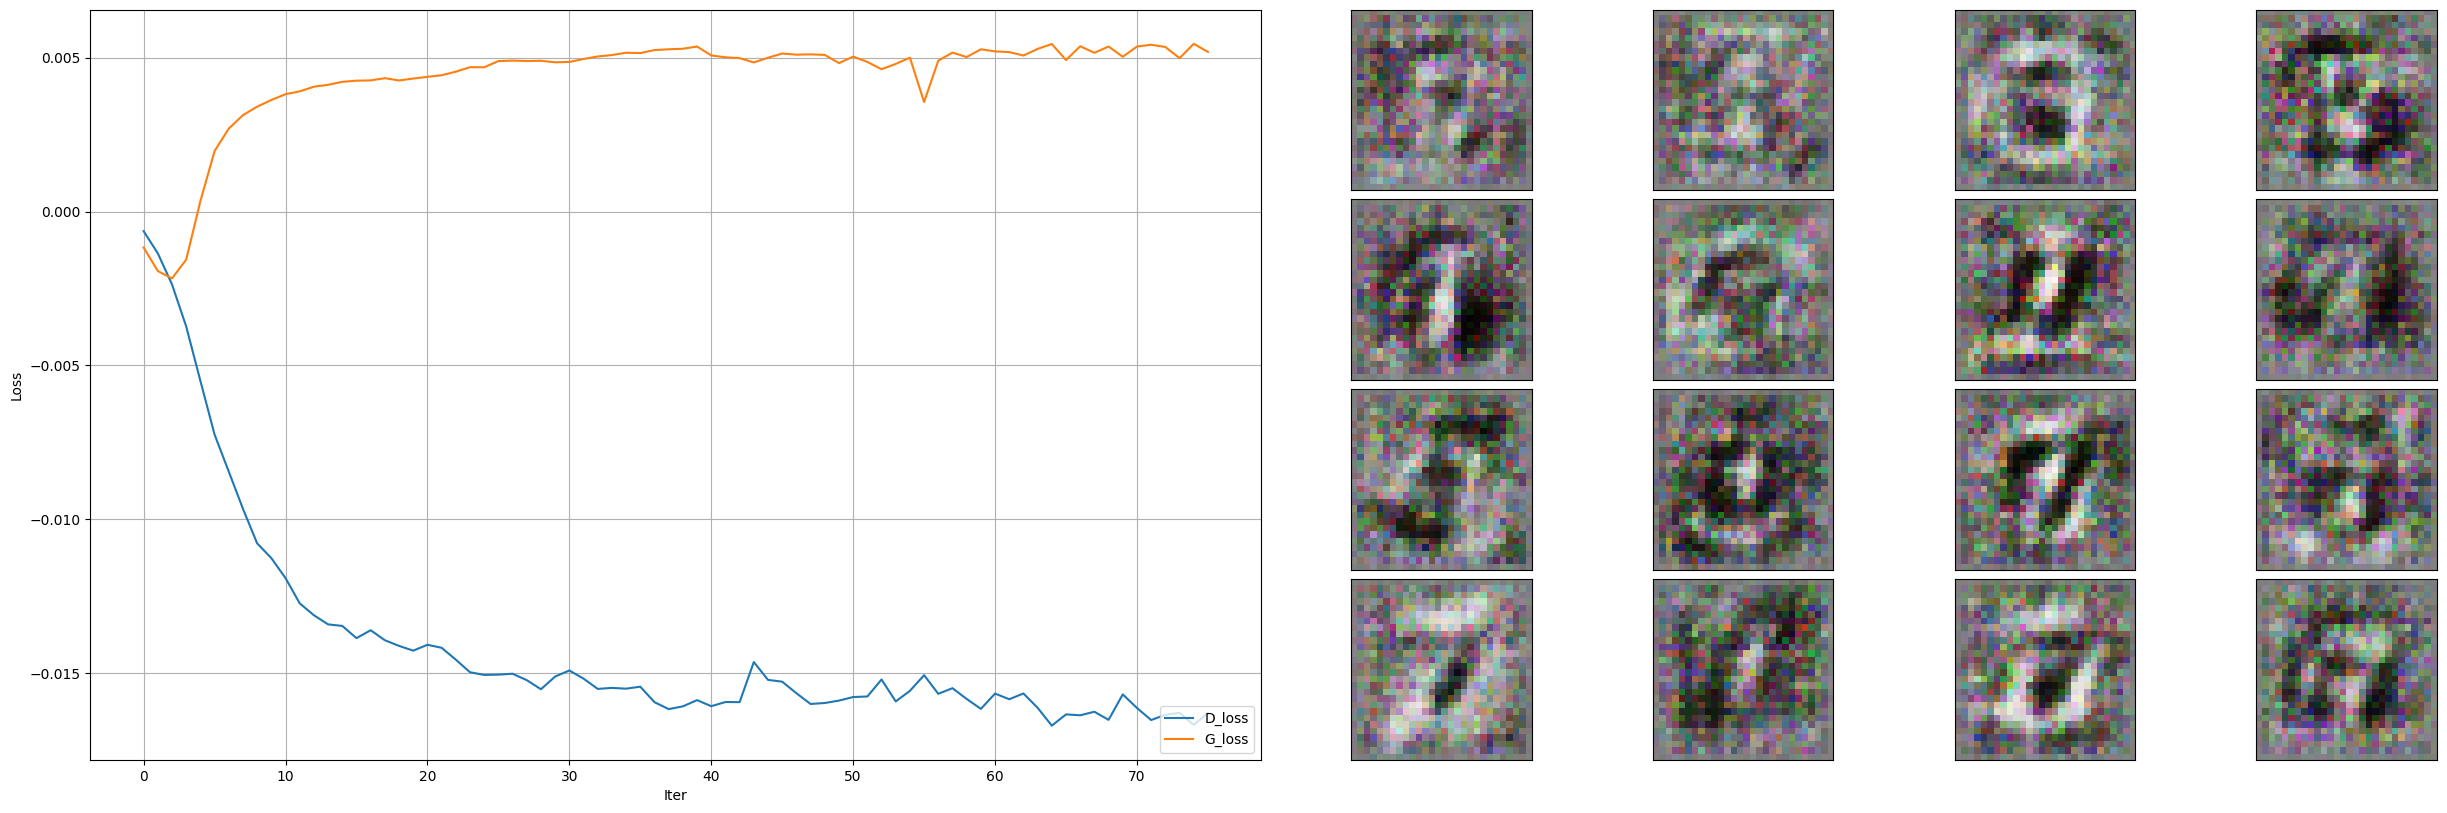

In [ ]:
# colab上での実行時間目安: 417秒
wgan = WGAN()  # 他のデータセットで学習する場合: WGAN(dataset='fashion-mnist'), WGAN(dataset='cifar10')
wgan.train()

### 3.4 DRAGAN

GANの学習は，$D$ と $G$ のmin-maxゲームが非凸であるために良くない局所的均衡点に達してmode collapseを起こしてしまうことが考えられます．[DRAGAN](https://arxiv.org/pdf/1705.07215.pdf) (Deep Regret Analytic GAN)の論文では，この局所的均衡点が実データの周りにおける $D$ の急勾配として現れることを実験的に確認しました．

<!--
$G$ はその種類の画像ばかり生成していれば $D$ を騙せると学習してしまう
-->

DRAGANでは**gradient penaltyによってそのような局所的均衡点を回避し，mode collapseの少ない安定した学習を実現しました**．

学習では以下の関数を最大化します．

\begin{aligned}
L _ { D } ^ { D R A G A N } & = L _ { D } ^ { G A N } - \lambda \mathbb{E}_{p_{data}(x),\,\delta \sim N_d(0, cI)} \left[ \left|\left| \nabla D \left( x + \delta \right) \right|\right| - 1 \right] ^2 \\
L _ { G } ^ { D R A G A N } & = L _ { G } ^ { G A N }
\end{aligned}

<!--

https://github.com/kodalinaveen3/DRAGAN/issues/6

実装が古いことがわかったので，表記・実装ともにアップデート

元の表記：
$$
\lambda E_{p_{data}(x)} \left[ \left( \left| \nabla D \left( \alpha x - \left( 1 - \alpha x _ { p } \right) \right) \right| - 1 \right) ^ { 2 } \right]
$$

-->

<!--
論文の最後のバージョンでは期待値の二乗になっているが，おそらく表記ミスなので二乗の期待値で表記．
-->

In [ ]:
class DRAGAN(object):
    def __init__(self, dataset='mnist'):
        self.epoch = 1
        self.sample_num = 16
        self.batch_size = 64
        self.input_size = 28
        self.z_dim = 62
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.dataset = dataset
        self.lambda_ = 0.25
        self.c = 10

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2))

        self.G.cuda()
        self.D.cuda()
        self.BCE_loss = nn.BCELoss().cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                """ DRAGAN Loss (Gradient penalty) """
                delta = self.c * torch.rand(x_.size()).cuda()
                interpolates = # WRITE ME
                interpolates.requires_grad = True

                pred_hat = self.D(interpolates)

                # Dの出力自体の勾配を計算
                gradients = grad(
                    outputs=# WRITE ME
                    inputs=# WRITE ME
                    grad_outputs=torch.ones(pred_hat.size()).cuda(),
                    create_graph=True, retain_graph=True, only_inputs=True
                )[0]

                # 本来の提案GP
                # gradient_penalty = gradients.view(gradients.size()[0], -1).norm(2, 1) - 1
                # gradient_penalty = self.lambda_ * (torch.maximum(
                #     torch.zeros_like(gradient_penalty),
                #     gradient_penalty)
                # ).mean()

                # More practical for optimization
                gradient_penalty = self.lambda_ * (gradients.view(gradients.size()[0], -1).norm(1, 1) - 1).mean() ** 2

                D_loss = D_real_loss + D_fake_loss + gradient_penalty
                self.train_hist['D_loss'].append(D_loss.item())
                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)

                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()

        plt.close()
        print("Training finish!")

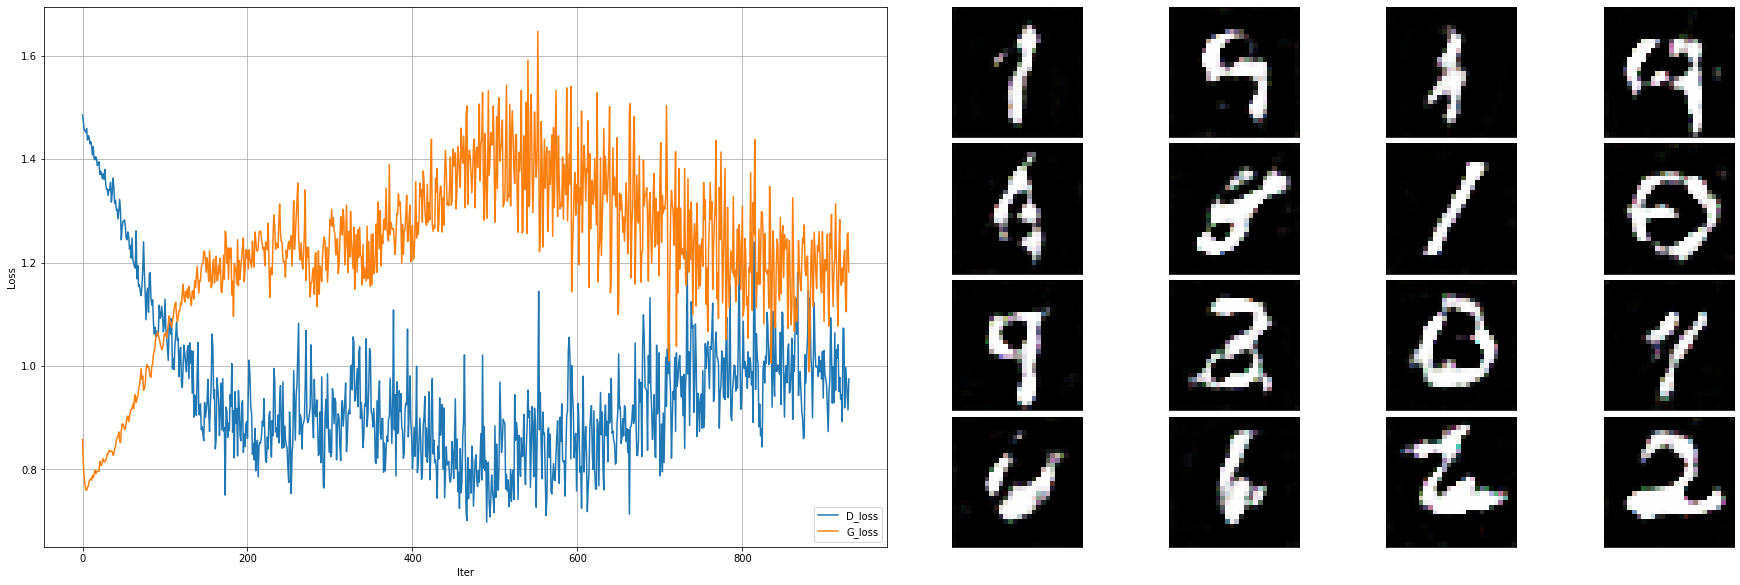

Training finish!


In [ ]:
# colab上での実行時間目安: 100秒
dragan = DRAGAN()  # 他のデータセットで学習する場合: DRAGAN(dataset='fashion-mnist'), DRAGAN(dataset='cifar10')
dragan.train()

### 3.5 BEGAN

[BEGAN: Boundary Equilibrium Generative Adversarial Networks](https://arxiv.org/abs/1703.10717)は，$D$ がオートエンコーダになっています．

通常のGANは生成モデルとデータ分布を近づけますが，**BEGANはそれらサンプルのオートエンコーダによる再構成誤差（mean absolute error）の分布を近づけるように学習を行います**．

実データと生成データの再構成誤差分布のWasserstein距離の下界から，以下の目的関数が導かれます（詳しくは論文参照）．

<br>

\begin{aligned} L _ { D } ^ { B E G A N } & = \mathbb{E}_{p_{data}(x)} \left[ D _ { A E } ( x )\right] - k _ { t }\mathbb{E}_{p(z)} \left[ D _ { A E } ( G ( z ) )\right] \\ L _ { G } ^ { B E G A N } & = \mathbb{E}_{p(z)} \left[ D _ { A E } ( G ( z ) )\right] \\ k _ { t + 1 } = & k _ { t } + \lambda_k \left( \gamma \mathbb{E}_{p_{data}(x)} \left[ D _ { A E } ( x )\right] - \mathbb{E}_{p(z)} \left[ D _ { A E } ( G ( z ) )\right] \right)
\end{aligned}
<br>


- $D$ と $G$ の学習のバランスを取るため，以下の平衡を保つことを目指しています．

$$
\gamma = \frac{\mathbb{E}_{p(z)}[D_{AE}(G(z))]}{\mathbb{E}_{p_{data}(x)}[D_{AE}(x)]}
$$

<!--
- $k_t \in [0,1]$ は $k_0=0$で初期化され，徐々に大きくなることで$D$が生成データの識別に重きをおくようになっていきます．
  - $D$ は最初は実データの再構成に重きを置き，だんだんと偽データを再構成**しないこと**に重きを置くイメージ
  - $G$ はずっと再構成誤差を小さくする
-->

- 訓練の最初の方では，$G$ の生成はすべてゼロに近くデータ分布も学習されていないので，$D$ にとって再構成しやすい
  - $k_t \in [0,1]$ は $k_0=0$で初期化されるので，この時点では $D$ は実データの再構成に重きをおく
  - フィードバックループにより学習を通じて $D_{AE}(x) > D_{AE}(G(z))$ が維持されつつ，$k_t$ は増加

<br>

収束の判断

- 加えて，以下で提案されたconvergence measureによって学習の収束具合を知ることができるのも利点です．

$$
\mathcal{M}_{global} = \mathbb{E}[D_{AE}(x)] + |\gamma \mathbb{E}[D_{AE}(x)] - \mathbb{E}[D_{AE}(G(z))]|
$$

<!--
「autoencoderの再構成誤差の絶対値」 -> 「autoencoderの再構成誤差（MAE; mean absolute error）」
-->

<!--

期待値やっぱり要る

\begin{aligned}
L _ { D } ^ { B E G A N } & = D _ { A E } ( x ) - k _ { t } D _ { A E } ( G ( z ) ) \\
L _ { G } ^ { B E G A N } & = D _ { A E } ( G ( z ) ) \\
k _ { t + 1 } \leftarrow & k _ { t } + \lambda_k \left( \gamma D _ { A E } ( x ) - D _ { A E } ( G ( z ) ) \right)
\end{aligned}

-->

In [ ]:
# オートエンコーダの実装
class began_discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(began_discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ELU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * (self.input_size // 2) * (self.input_size // 2), 32),
            nn.Linear(32, 64 * (self.input_size // 2) * (self.input_size // 2)),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, self.output_dim, kernel_size=4, stride=2, padding=1),
        )

        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        x = x.view(-1, 64, (self.input_size // 2), (self.input_size // 2))
        x = self.deconv(x)

        return x

In [ ]:
class BEGAN(object):
    def __init__(self, dataset='mnist'):
        self.epoch = 3
        self.sample_num = 16
        self.batch_size = 64
        self.input_size = 28
        self.z_dim = 62
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.dataset = dataset
        self.gamma = 1
        self.lambda_ = 0.001
        self.k = 0.0
        self.lr_lower_boundary = 0.00002

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = began_discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=0.0002, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=0.0002, betas=(self.beta1, self.beta2))

        self.G.cuda()
        self.D.cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.M = {}
        self.M['pre'] = []
        self.M['pre'].append(1)
        self.M['cur'] = []
        k_hist = []

        # self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        # self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()

        start_time = time.time()
        for epoch in range(self.epoch):
            self.G.train()
            epoch_start_time = time.time()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))

                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                # 再構成誤差
                D_real_loss = torch.mean(torch.abs(D_real - x_))

                G_ = self.G(z_)
                D_fake = self.D(G_)
                # 再構成誤差
                D_fake_loss = torch.mean(torch.abs(D_fake - G_))

                D_loss = D_real_loss - self.k * D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                # 再構成誤差
                D_fake_loss = torch.mean(torch.abs(D_fake - G_))

                G_loss = D_fake_loss
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                # convergence measure
                temp_M = D_real_loss + torch.abs(self.gamma * D_real_loss - G_loss)

                # operation for updating k
                temp_k = self.k + self.lambda_ * (self.gamma * D_real_loss - G_loss)
                temp_k = min(max(temp_k.item(), 0), 1)

                self.k = temp_k
                k_hist.append(temp_k)
                self.M['cur'] = temp_M.item()

                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()


            # 学習率の更新とconvergence measureの保存
            if np.mean(self.M['pre']) < np.mean(self.M['cur']):
                pre_lr = self.G_optimizer.param_groups[0]['lr']
                self.G_optimizer.param_groups[0]['lr'] = max(self.G_optimizer.param_groups[0]['lr'] / 2.0,
                                                             self.lr_lower_boundary)
                self.D_optimizer.param_groups[0]['lr'] = max(self.D_optimizer.param_groups[0]['lr'] / 2.0,
                                                             self.lr_lower_boundary)
                print('M_pre: ' + str(np.mean(self.M['pre'])) + ', M_cur: ' + str(
                    np.mean(self.M['cur'])) + ', lr: ' + str(pre_lr) + ' --> ' + str(
                    self.G_optimizer.param_groups[0]['lr']))
            else:
                print('M_pre: ' + str(np.mean(self.M['pre'])) + ', M_cur: ' + str(np.mean(self.M['cur'])))
                self.M['pre'] = self.M['cur']

                self.M['cur'] = []

        plt.close()
        print("Training finish!")

        return k_hist, self.M['cur']

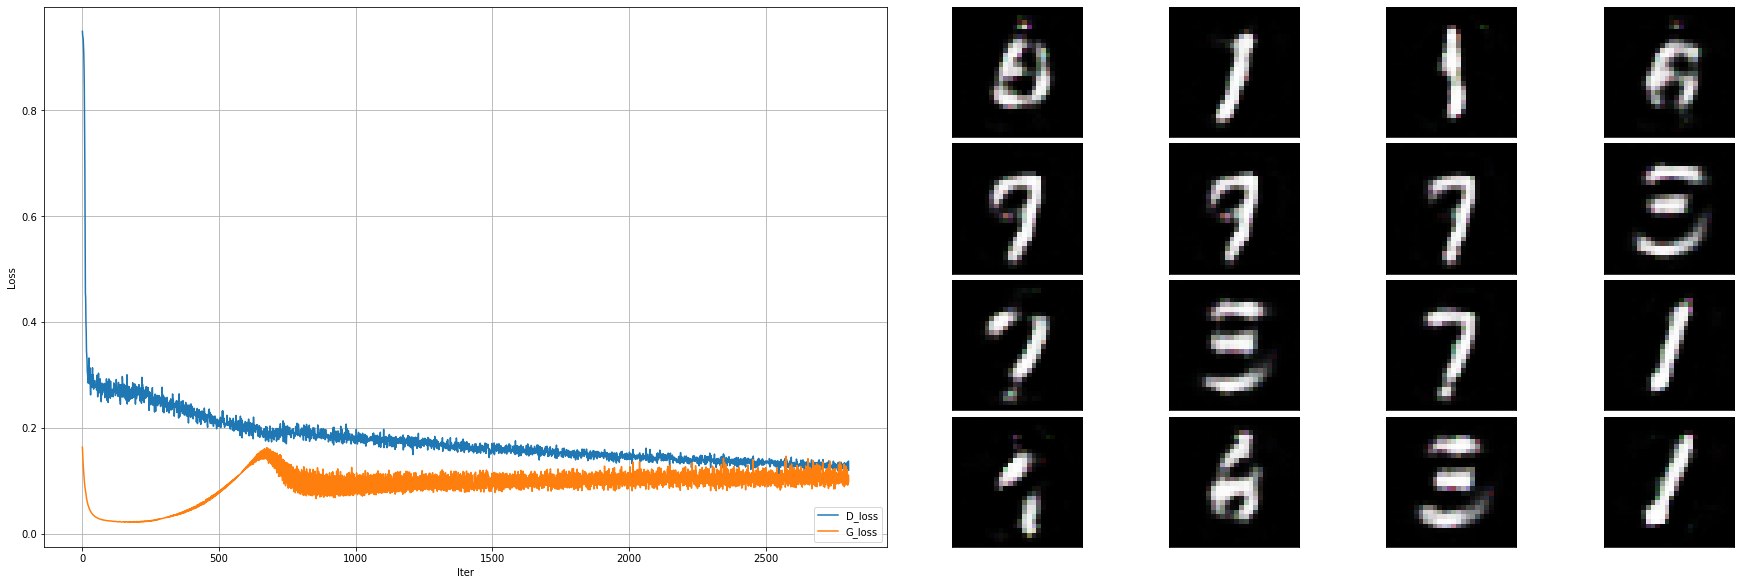

M_pre: 0.25018808245658875, M_cur: 0.21039418876171112
Training finish!


In [ ]:
# colab上での実行時間目安: 270秒
began = BEGAN()  # 他のデータセットで学習する場合: BEGAN(dataset='fashion-mnist'), BEGAN(dataset='cifar10')
k_hist, M_hist = began.train()

$k_t$ が単調増加していることを確認します．

Text(0, 0.5, 'k')

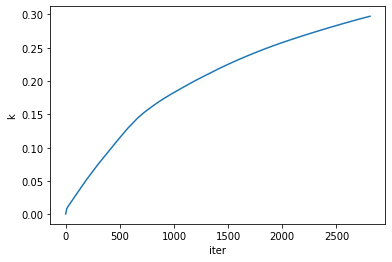

In [ ]:
plt.plot(k_hist)
plt.xlabel("iter"); plt.ylabel("k")

### 3.6 SNGAN

GANの学習の安定化において重要なのは，$D$ の目的関数の連続性です．

[Spectral Normalization for Generative Adversarial Networks](https://arxiv.org/abs/1802.05957)は，$D$ のBatch Normalizationを**Spectral Normalizationに置き換えることでリプシッツ連続性を確保**し，学習安定性を向上させました．

<br>

あるニューラルネット $f_{\theta}(\mathbf{x}) = W^{L+1 \, }a_L (W^L \,a_{L-1} (W^{L-1} ...\; a_1(W^1 \mathbf{x})...))$ を考えます．

- 合成関数のリプシッツノルムはそれらのリプシッツノルムの積以下になること
$$
\|g_1 \circ g_2 \|_{Lip} \leq \|g_1\|_{Lip} \cdot \|g_2\|_{Lip}
$$

- 活性化関数ReLU, LeakyReLUのリプシッツノルムが1になること（他の活性化関数についても定数になる）
$$
\|a_l\|_{Lip} = 1
$$

- ある線形層のリプシッツノルムは，スペクトルノルムに等しいこと
$$
\|g\|_{Lip} = \sigma(W)
$$

<br>

以上から，ニューラルネット $f_{\theta}$ のリプシッツノルムは各層重みのスペクトルノルムの積以下になります．

$$
\|f_{\theta}\|_{Lip} \leq \prod_{l=1}^{L+1} \underbrace{\sigma(W^l)}_{スペクトルノルム}
$$

つまり，**各層をそのスペクトルノルムで正規化しておけば，ニューラルネットのリプシッツ連続性を確保できる**ことになります．

<br>

**Power Iteration Method**

スペクトルノルムの計算は難しく計算量も多いので，以下のPower Iterationという方法により近似されます．（詳細は論文 appendix A）

1. レイヤー $l=1,...,L$ について，ベクトル $\tilde{\bf u}_l$ を初期化

1. 重み更新の度に以下実行

  - ベクトル $\tilde{\bf v}_l$, $\tilde{\bf u}_l$ を更新

  $$
  \tilde{\bf v}_l \leftarrow \frac{(W^l)^T \tilde{\bf u}_l}{||(W^l)^T \tilde{\bf u}_l||_2} \qquad \tilde{\bf u}_l \leftarrow \frac{W^l \tilde{\bf v}_l}{||W^l \tilde{\bf v}_l||_2}
  $$

  - スペクトルノルム $\sigma(W^l)$ を計算し，正規化

  \begin{aligned}
  \sigma(W^l) &\approx \tilde{\bf u}_l^TW^l \tilde{\bf v}_l \\
  W^l_{SN} &= \frac{W^l}{\sigma(W^l)}
  \end{aligned}

In [ ]:
class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            # vベクトルの更新
            # https://pytorch.org/docs/stable/generated/torch.mv.html
            v.data = self._l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            # uベクトルの更新
            u.data = self._l2normalize(torch.mv(w.view(height,-1).data, v.data))

        sigma = u.dot(w.view(height, -1).mv(v))
        # レイヤーのWをW_SNに置き換える
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False

    def _make_params(self):
        w = getattr(self.module, self.name)

        # Conv2dのweight matrixは4次元
        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        # new()で同じdtypeの新しいTensorを作り，normal_(mean, std)で初期化
        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False) # ( h, )
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False) # ( w, )
        u.data = self._l2normalize(u.data)
        v.data = self._l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)

    def _l2normalize(self, v, eps=1e-12):
        return v / (v.norm() + eps)

    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [ ]:
class sngan_discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(sngan_discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            SpectralNorm(nn.Conv2d(self.input_dim, 64, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.2),
            SpectralNorm(nn.Conv2d(64, 64, 4, stride=2, padding=(1,1))),
            nn.LeakyReLU(0.2),
            SpectralNorm(nn.Conv2d(64, 128, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.2),
            SpectralNorm(nn.Conv2d(128, 128, 4, stride=2, padding=(1,1))),
            nn.LeakyReLU(0.2),
            SpectralNorm(nn.Conv2d(128, 256, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.2),
        )

        self.fc = nn.Sequential(
            SpectralNorm(nn.Linear(256 * (self.input_size//4) * (self.input_size//4), self.output_dim)),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x.view(-1, 256 * (self.input_size//4) * (self.input_size//4)))

        return x

In [ ]:
class SNGAN(object):
    def __init__(self, dataset='mnist'):
        self.epoch = 3
        self.sample_num = 16
        self.batch_size = 64
        self.input_size = 28
        self.z_dim = 62
        self.lrG = 0.0002
        self.lrD = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.dataset = dataset # mnist, fashion-mnist, cifar10


        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = sngan_discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=self.lrG, betas=(self.beta1, self.beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=self.lrD, betas=(self.beta1, self.beta2))

        self.G.cuda()
        self.D.cuda()
        self.BCE_loss = nn.BCELoss().cuda()

        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        for epoch in range(self.epoch):
            self.G.train()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                if ((iter + 1) % 10) == 0:
                    with torch.no_grad():
                        tot_num_samples = min(self.sample_num, self.batch_size)
                        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
                        display_process(self.train_hist, self.G, image_frame_dim, self.sample_z_)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        plt.close()

        plt.close()
        print("Training finish!")

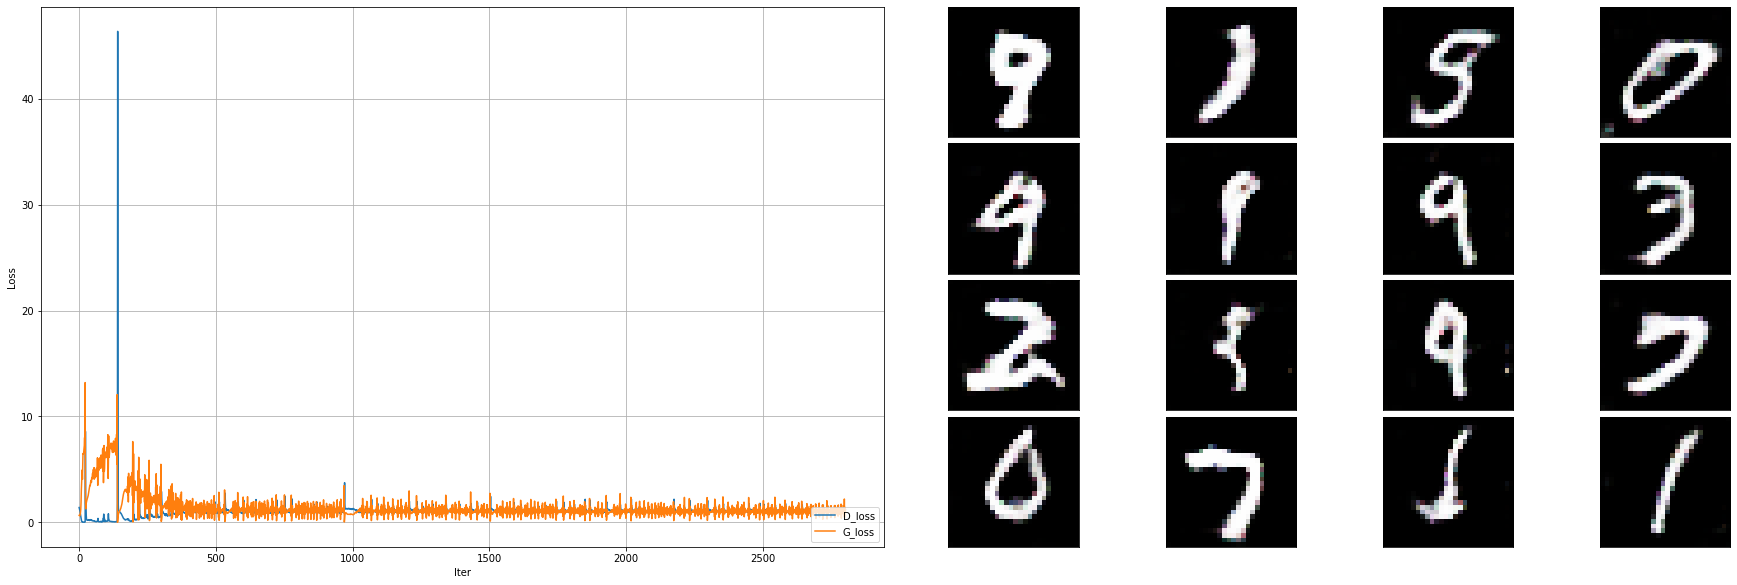

Training finish!


In [ ]:
# colab上での実行時間目安: 330秒
sngan = SNGAN()  # 他のデータセットで学習する場合: SNGAN(dataset='fashion-mnist'), SNGAN(dataset='cifar10'
sngan.train()

## 4.参考文献

[[1]](https://arxiv.org/pdf/1406.2661.pdf) Goodfellow et al., "Generative Adversarial Nets", arXiv:1406.2661, 2014

[[2]](https://arxiv.org/pdf/1611.04076.pdf) Mao et al., "Least Squares Generative Adversarial Networks", arXiv:1611.04076, 2017

[[3]](https://arxiv.org/pdf/1701.07875.pdf) Arjovsky et al., "Wasserstein GAN", arXiv:1701.07875, 2017

[[4]](https://arxiv.org/pdf/1705.07215.pdf) Kodali et al., "On Convergence and Stability of GANs", arXiv:1705.07215, 2017

[[5]](https://arxiv.org/pdf/1703.10717.pdf) Berthelot et al., "BEGAN: Boundary Equilibrium Generative Adversarial Networks", arXiv:1703.10717, 2017

[[6]](https://arxiv.org/pdf/1802.05957.pdf) Miyato et al., "Spectral Normalization for Generative Adversarial Networks", arXiv:1802.05957, 2018